In [44]:
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
from IPython.display import Audio


In [45]:
def normalize(signal):
    
    highest = 0
    
    for s in signal:
        
        if abs(s) > highest:
            highest = abs(s)
    
    signal *= (1 / highest)
    return signal

samplerate = 16000
audio length = 40 seconds
array lenght = 644280 samples


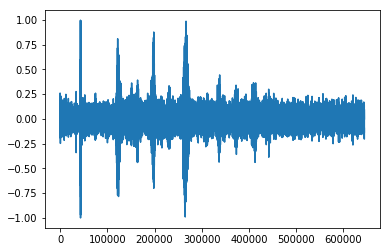

In [65]:
#opening a wav file --- our trusty sitar#opening 

audio, samplerate = sf.read('pepper_sample_1.wav')
buffersize = 156

#we want to zero pad the file so that it will emulate a realtime stream
signal = np.append(audio, np.full(buffersize - (len(audio) % buffersize), 0.0))

#normalise signal
signal = normalize(signal)

print('samplerate = {}'.format(samplerate))
print('audio length = {} seconds'.format(len(audio)/samplerate))
print('array lenght = {} samples'.format(len(audio)))
plt.plot(signal)
plt.show()

display(Audio(signal, rate=samplerate))

In [100]:
#we can put this in a genorator

def buffer_gen(audio, buffersize):

    index = 0
    while index < len(audio):
        yield(audio[index:index+buffersize])
        index += buffersize
    return

In [109]:
def de_interleave(signal):
    #takes the four channels and comines it to one
    first = np.zeros(len(signal) / 4)
    second = np.zeros(len(signal) / 4)
    third = np.zeros(len(signal) / 4)
    forth = np.zeros(len(signal) / 4)

    ind  = 0
    for i in range(0, len(signal), 4):
        first[ind] = signal[i] 
        second[ind] = signal[i+1]
        third[ind] = signal[i + 2]
        forth[ind] = signal[i + 3]
        ind += 1
        
    return (first + second + third + forth) / 4

In [110]:
#beamform this

class RT_BF:
    
    def __init__(self, offset):
        self.offset_num = offset
        self.lastOffsetBuffer = np.zeros(offset)
        return
    
    def process(self, signal, samplerate):

        #separate the interleaved file
        first = np.zeros(len(signal) / 4)
        second = np.zeros(len(signal) / 4)
        third = np.zeros(len(signal) / 4)
        forth = np.zeros(len(signal) / 4)

        ind  = 0
        for i in range(0, len(signal), 4):
            first[ind] = signal[i] 
            second[ind] = signal[i+1]
            third[ind] = signal[i + 2]
            forth[ind] = signal[i + 3]
            ind += 1

        #rename them for corresponding mics
        fl = forth 
        fr = third 
        bl = second
        br = first

        #save the leftovers for the next process call
        tmp = (fl + fr)[0-self.offset_num:]
        if (len(self.lastOffsetBuffer) != self.offset_num):
            print('error mismatch thing')
        
        #beam-form and re-merge the signal into on channel
        front = np.append( self.lastOffsetBuffer, (fl + fr)[:0-self.offset_num] )
        beamed = (front + bl + br) / 4
        
        self.lastOffsetBuffer = tmp
        
        return beamed
    
    def reset(self):
        self.lastOutputBuffer = np.zeros(self.offset_num)



In [111]:
#so now we try with a real time IIR filter

class IIR_realtime():
    
    def __init__(self, b, a):

        #filter coeficiants
        self.A = a
        self.B = b / a[0]
        
        #lengths of coeficiants
        self.M = len(self.B)
        self.Q = len(self.A)
        
        self.clean_last_overlap = np.full(self.M, 0.0)
        self.last_overlap = np.full(self.M, 0.0)
        
    def process(self, signal):
        
        #append the last overlap and get the next ---- this is really not so efficiant
        sigLen = len(signal)
        
        signal = np.append(self.clean_last_overlap, signal)
        
        #convolve the signal
        output = np.append(self.last_overlap, np.full(sigLen, 0.0))

        for N in range(self.M, len(signal)):

            output[N] = self.B[0] * signal[N]

            for K in range(1, self.M):

                feedback = (self.A[K] * output[N-K])

                output[N] += (self.B[K] * signal[N - K]) - feedback
                
        self.clean_last_overlap = signal[sigLen:]
        self.last_overlap = output[sigLen:]
        
        output = output[:sigLen]

        return output
        
    def set_coefs(self, b, a):
        #in this implementation can't change the order
        self.A = a
        self.B = b

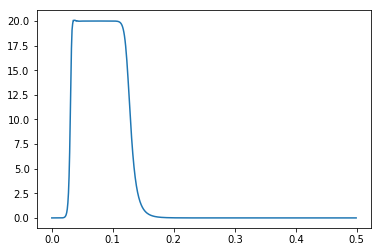

In [138]:
#coefs
#a window that we can test with
order = 10
ripple = .6
cuttoff = 400

low = 500
high = 2000

#b, a = sig.cheby1(order, ripple, cuttoff, 'high', fs=samplerate)
#b, a = sig.butter(order, cuttoff, 'high', fs=samplerate)
b, a = sig.butter(order, [low, high], 'bp', fs=samplerate)
#b, a = sig.cheby1(order, ripple, [low, high], 'bp', fs=samplerate)


#plot this
w, h = sig.freqz(b, a)
plt.plot(w/np.pi/2, 20 * np.abs(h))
plt.show()

In [139]:
original = de_interleave(signal)

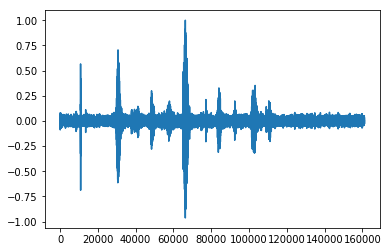

In [140]:
buffers = buffer_gen(signal, buffersize)

bf = RT_BF(4)
filt = IIR_realtime(b, a)

output = np.empty(0)

for buf in buffers:
    buf = bf.process(buf, samplerate)
    buf = filt.process(buf)
    output = np.append(output, buf)
    
plt.plot(normalize(output))
plt.show()

display(Audio(output, rate=samplerate))

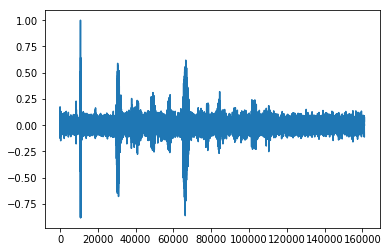

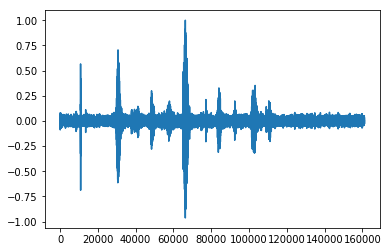

In [141]:
plt.plot(normalize(original))
plt.show()

plt.plot(normalize(output))
plt.show()

### Now we can test these two with google